<a href="https://colab.research.google.com/github/unverciftci/GMR/blob/master/NewGenModReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresion with flows

This notebook shows some first steps using flows for regression.

In [1]:
# Required packages
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
# Define a sixth-order polynomial 
n = 200
x = np.linspace(-4, 4, n+1, dtype=np.float32)
f = lambda x: -0.001*(x)*(x-4)*(x+4)*(x+3)*(x-3)*(x-1) # -1

# Unnoisy data points
X_unnoisy = f(x)
np.random.seed(1)
# Noisy data points
X = np.array([a +  0.03 * np.random.normal(0,1) for a in X_unnoisy], dtype=np.float32)

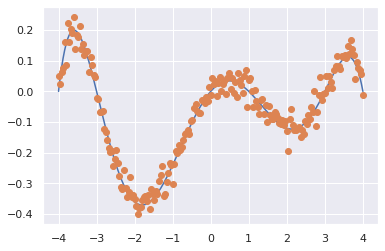

In [3]:
plt.plot(x, f(x))
plt.plot(x, X, 'o')

In [28]:
# Define the normalizing flow

num_bijectors = 30
bs=[]
for i in range(num_bijectors):
    
    shift = tf.Variable(0.0)
    scale=tf.Variable(1.0)
    bs.append(tfb.Shift(shift)(tfb.Scale(scale)))
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))
    
bijector = tfb.Chain(bs) 
dist = tfd.TransformedDistribution(distribution=
        #tfd.Uniform(low=0.0, high=1.0),bijector=bijector)
        tfd.Normal(loc=0,scale=1),bijector=bijector) 

In [29]:
# Estimator of the normalizing constant
logK = tf.Variable(1.0, dtype=tf.float32) 

In [30]:
trainable_vars = dist.trainable_variables + (logK,)

In [31]:
# Optimization staff

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

@tf.function #Compiles function for fast execution
def train_step(x):
    with tf.GradientTape() as tape:
        loss = tf.keras.losses.MSE(X, -dist.log_prob(x) - logK)
        gradients = tape.gradient(loss, trainable_vars)    
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        return loss

In [37]:
# Training
for i in range(5001):
    loss = train_step(x)
    if (i % 1000 == 0):
      print(i, "Loss ", loss.numpy())

0 Loss  0.00093843363
1000 Loss  0.0008322659
2000 Loss  0.00077955256
3000 Loss  0.0029166213
4000 Loss  0.0007395359
5000 Loss  0.00073234306


In [38]:
# Regressor

f_pred = -dist.log_prob(x) - logK

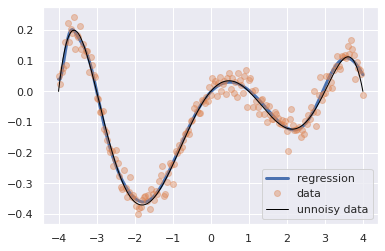

In [39]:
plt.plot(x, f_pred, linewidth=3, label='regression')
plt.plot(x, X, 'o', label='data', alpha=0.4)
plt.plot(x, f(x), 'black',linewidth=1, label='unnoisy data')
plt.legend()

Text(0, 0.5, 'z')

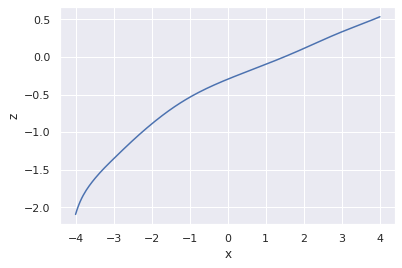

In [40]:
plt.plot(x, bijector.inverse(x))
plt.xlabel('x')
plt.ylabel('z')



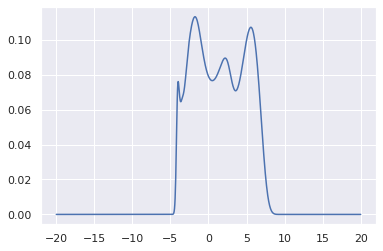

In [41]:
y = np.linspace(-20,20,1000)
P = dist.prob(y)
plt.plot(y, P)